In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
import torch.nn.functional as F
import numpy as np
from numpy import genfromtxt
import os
import pickle
from matplotlib import pyplot as plt
import sys
sys.path.append("../../../")
from utils.utils import MyDataset, MyDatasetV2, show_image, visualise_output
from networks.autoencoder import FireAutoencoder
from networks.autoencoder_reward import FireAutoencoder_reward
from networks.vae import VAE
from networks.vae_v2 import VAE_V2
from networks.ccvae import CCVAE
from networks.utils import EarlyStopper
import argparse
from algorithms.GA.utils import write_firewall_file, erase_firebreaks
from tqdm import tqdm


In [3]:
dataset = MyDatasetV2("../../../../data/complete_random/homo_2/")

In [4]:
params = {

}
params["latent_dims"] = 256
params["capacity"] = 128
params["use_gpu"] =  False
params["input_size"] = 20
params["epochs"] = 20
params["sigmoid"] = True
params["lr1"] = 1e-05
params["lr2"] = 1e-05
params["instance"] = "homo_2"
params["not_reduced"] = False
params["variational_beta"] = 0.1
params["distribution_std"] = 0.1
params["latent_portion"] = 0.5
params["alpha"] = 1000

In [5]:
model = CCVAE(params).to("cpu")
model.eval()

CCVAE(
  (conv1): Conv2d(4, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc_mu): Linear(in_features=6400, out_features=256, bias=True)
  (fc_logvar): Linear(in_features=6400, out_features=256, bias=True)
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (encoder): Sequential(
    (0): Conv2d(4, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU()
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.5, inpla

In [6]:
# Load weights
#burned_loss_sub20x20_latent=256_capacity=128_20_sigmoid=True_lr1=1e-05_not_reduced=False_variational_beta=0.1_distribution_std=1.0
model.load_state_dict(torch.load(f'../../../weights/homo_2/CCVAE/sub20x20_latent=256_capacity=128_100_sigmoid=True_T1=100_T2=100_lr1=1e-05_lr2=1e-05_lr3=0.0001_normalize=False_weight_decay=0_not_reduced=False_variational_beta=0.1_distribution_std=0.1_alpha=10000.0.pth', map_location=torch.device('cpu') ))

/tmp/ipykernel_1407965/1608866536.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'../../../weights/homo_2/CCVAE/sub20x20_latent=256_ca

<All keys matched successfully>

In [7]:
x, r = dataset[6]
recon, r_ = model(x.unsqueeze(0), r.unsqueeze(0))

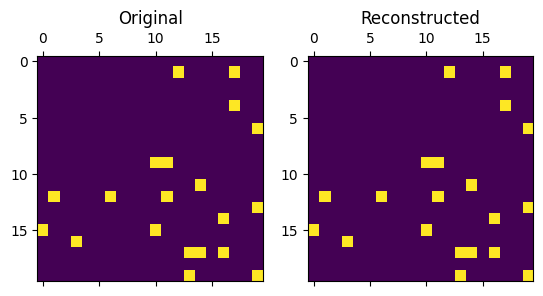

In [8]:
# Plotting the original binary matrix
plt.subplot(1, 2, 1)
plt.title('Original')
plt.matshow((x[0] > 0).int(), fignum=False)

# Plotting the reconstructed binary matrix
plt.subplot(1, 2, 2)
plt.title('Reconstructed')
plt.matshow((recon[0] >= 0.5)[0].int(), fignum=False)
plt.show()

In [9]:
# plot both solutions side by side
r, r_


(tensor([0.7225]), tensor([[0.7237]], grad_fn=<SigmoidBackward0>))

In [10]:
burned_r = []
for x, r in tqdm(dataset):
    _, r_ = model(x.unsqueeze(0), r.unsqueeze(0))
    burned_r.append(r_.item())

100%|██████████| 50000/50000 [03:12<00:00, 259.21it/s]


In [32]:
original_burned = []
rel_e = []
abs_e = []
for i,v in enumerate(dataset):
    x,r = v
    original_burned.append(r)
    abs_e.append(burned_r[i] - original_burned[i][0])
    rel_e.append((burned_r[i] - original_burned[i][0])/original_burned[i][0])


In [27]:
print(burned_r[0])
original_burned[0]

0.7211598753929138


tensor([0.7227])

In [29]:
e[233]

tensor(0.0009)

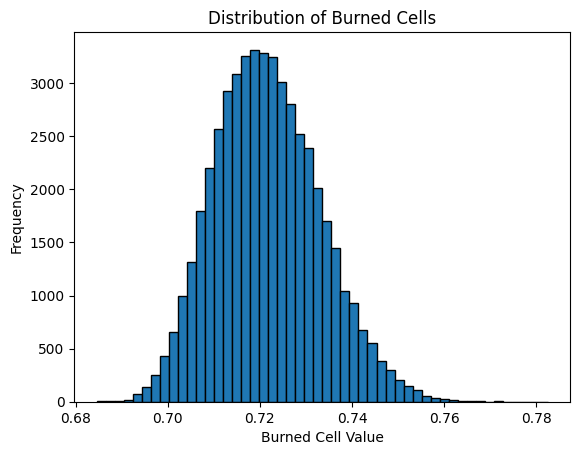

In [16]:
# plotting the distribution of burned_r
plt.hist(burned_r, bins=50, edgecolor='black')
plt.title('Distribution of Burned Cells')
plt.xlabel('Burned Cell Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
len(e)

50000

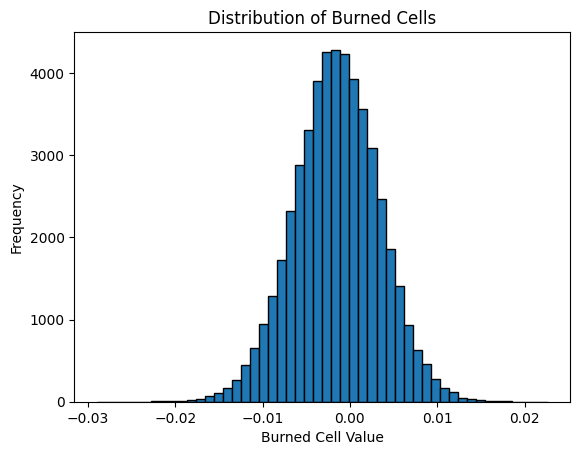

In [98]:
# plotting the distribution of burned_r
plt.hist(abs_e, bins=50, edgecolor='black')
plt.title('Distribution of Burned Cells')
plt.xlabel('Burned Cell Value')
plt.ylabel('Frequency')
plt.show()

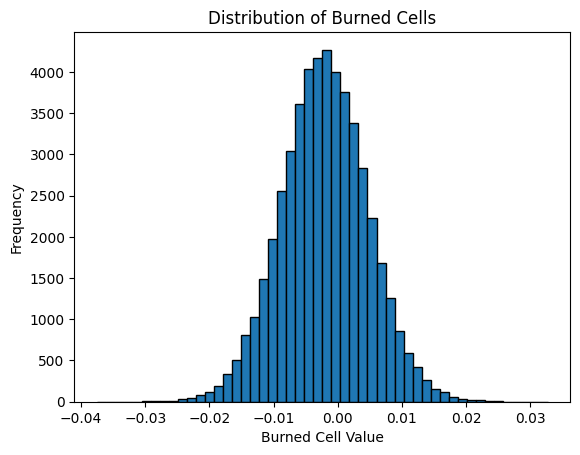

In [35]:
# plotting the distribution of burned_r
plt.hist(rel_e, bins=50, edgecolor='black')
plt.title('Distribution of Burned Cells')
plt.xlabel('Burned Cell Value')
plt.ylabel('Frequency')
plt.show()

In [37]:
model.training = True

In [ ]:
x, r = dataset[np.argmax(burned_r)]
mu, log_sigma = model.encode(x.unsqueeze(0))
x, r = dataset[np.argmin(burned_r)]
mu_, log_sigma_ = model.encode(x.unsqueeze(0))
alpha = 0.5
interp = alpha * mu + (1 - alpha) * mu_

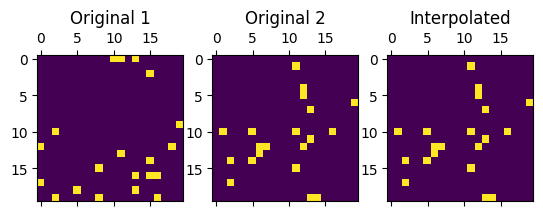

In [41]:
# Plot the original image and the sampled image and interp
plt.subplot(1, 3, 1)
plt.title('Original 1')
plt.matshow((x[0] > 0).int(), fignum=False)

plt.subplot(1, 3, 2)
plt.title('Original 2')
plt.matshow(model.decode(interp)[0][0] >= 0.5, fignum=False)

plt.subplot(1, 3, 3)
plt.title('Interpolated')
plt.matshow(model.decode(interp)[0][0] >= 0.5, fignum=False)

plt.show()


In [108]:
def calc_fitness(model, embedding, n_sims = 50):
        """
        Calculates the average number of burned cells of embedding's associated
        solution.
        """
        # print(embedding.shape)
        solution = model.decode(embedding[0])
        _, indices = torch.topk(solution.flatten(), 20)
        indices = np.unravel_index(indices, (20, 20))
        matrix = torch.zeros((20, 20))
        matrix[indices] = 1.
        assert(matrix.sum().item() == 20)
        write_firewall_file(matrix * -1.)
        n_weathers = len([i for i in os.listdir("../../../../data/complete_random/homo_2/Sub20x20/Weathers/") if i.endswith('.csv')])-2
        exec_str = f"../../../algorithms/eval/C2F-W/Cell2Fire/Cell2Fire --input-instance-folder ../../../../data/complete_random/homo_2/Sub20x20/ --output-folder ../../../algorithms/eval/results/ --sim-years 1 --nsims {n_sims}--Fire-Period-Length 1.0 --output-messages --ROS-CV 2.0 --seed 123 --weather random --ignitions --IgnitionRad 4 --sim C --final-grid --nweathers {n_weathers} --FirebreakCells ../../../algorithms/eval/harvested/HarvestedCells.csv"
        os.system(exec_str + " >/dev/null 2>&1")
        reward = 0
        base_directory = f"../../../algorithms/eval/results/Grids/Grids"
        for j in range(1, n_sims+1):
            dir = f"{base_directory}{str(j)}/"
            # print(dir)
            files = os.listdir(dir)
            my_data = genfromtxt(dir+files[-1], delimiter=',')
            # Burned cells are counted and turned into negative rewards
            for cell in my_data.flatten():
                if cell == 1:
                    reward-= 1
        erase_firebreaks()
        return 1 + ((reward/n_sims) / 400)

In [43]:
calc_fitness(model, mu_.unsqueeze(0), n_sims=10)

torch.Size([1, 1, 256])


/tmp/ipykernel_1407965/4204403387.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  indices = np.unravel_index(indices, (20, 20))


0.67125

In [93]:
def top20(tensor):
    shape = tensor.shape
    # Return a tensor with the same size as the input tensor, but with only the top 20 as 1 and the rest as 0
    top20 = torch.topk(tensor.view(-1), 20)[1]
    tensor = torch.zeros_like(tensor.view(-1))
    tensor[top20] = 1
    return tensor.view(shape)

torch.Size([1, 1, 256])


/tmp/ipykernel_1407965/4204403387.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  indices = np.unravel_index(indices, (20, 20))


torch.Size([1, 256])
torch.Size([1, 1, 256])


/tmp/ipykernel_1407965/2915693828.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  indices = np.unravel_index(indices, (20, 20))


torch.Size([1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 256])
torch.Size([1, 1, 256])
torch.Size([1, 256])


/tmp/ipykernel_1407965/2915693828.py:29: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  diff = sum(sum(np.abs(mat_aa))).item()


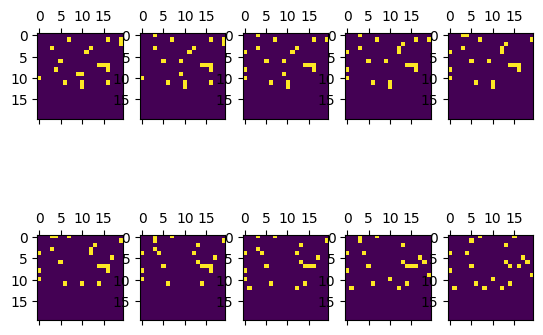

0
4.0
4.0
4.0
2.0
6.0
8.0
4.0
8.0
6.0
[0, 4.0, 4.0, 4.0, 2.0, 6.0, 8.0, 4.0, 8.0, 6.0]


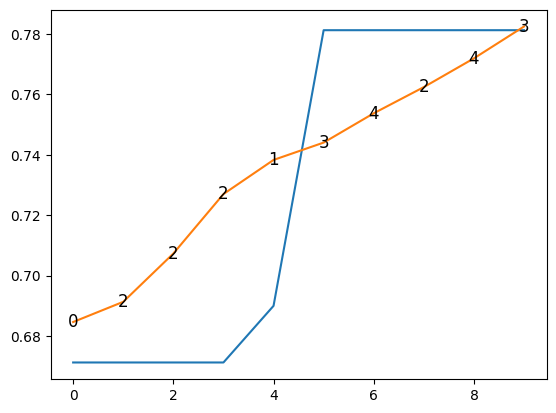

(array([ 6, 12,  5,  7,  4, 12, 11,  0,  2, 11,  9,  6,  7,  1,  0,  4,  8,
       12, 10,  7]), array([13, 12, 17,  5,  4,  1,  6,  7, 13, 14, 19, 18, 16,  5, 15,  0,  0,
        8, 10, 14]))


In [97]:
n = 10
interpolations = []
values = []
predictions = []
matrices = []
# make a linear interpolation between mu and mu_
# plot the n images
for alpha_ in range(n):
    alpha = alpha_/(n-1)
    interp = alpha * mu + (1 - alpha) * mu_
    interpolations.append(interp)
    values.append(calc_fitness(model, interp.unsqueeze(0), n_sims=10))
    print(interp.shape)
    aa = model.predict_burned(interp).detach().numpy()
    predictions.append(aa[0][0])

    _, indices = torch.topk(interp.flatten(), 20)
    matrix = torch.zeros((20, 20))
    indices = np.unravel_index(indices, (20, 20))
    matrix[indices] = 1
    matrices.append(matrix)
    assert(matrix.sum().item() == 20)
    plt.subplot(2, n//2, alpha_+1)
    plt.matshow(matrix, fignum=False)

diffs = [0]
for i in range(n-1):
    mat_aa = matrices[i] - matrices[i+1]
    diff = sum(sum(np.abs(mat_aa))).item()   
    diffs.append(diff)

plt.show()
# plot the values
plt.plot(values)
plt.plot(predictions)
# plt.plot(diffs)
for i,diff in enumerate(diffs):
    print(diff)
    plt.text(i, predictions[i], str(int(diff/2)), color='black', fontsize=12, ha='center', va='center')
print(diffs)
plt.show()
print(indices)

torch.Size([20, 20])
torch.Size([4, 20, 20])


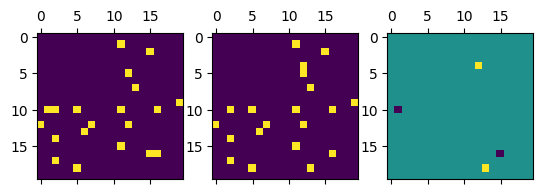

In [96]:
x, r = dataset[np.argmax(burned_r)]
mu, log_sigma = model.encode(x.unsqueeze(0))
x, r = dataset[np.argmin(burned_r)]
mu_, log_sigma_ = model.encode(x.unsqueeze(0))
alpha = 0.5
interp = alpha * mu + (1 - alpha) * mu_

rec_interp = model.decode(interp).squeeze()
print(rec_interp.shape)
y,r = dataset[0]
y[0] = rec_interp
print(y.shape)
# input rec_interp to the model and see the output
a,b = model.encode(y.unsqueeze(0))
aaa = model.decode(a)
plt.subplot(1, 3, 1)
plt.matshow(top20(rec_interp), fignum=False)
plt.subplot(1, 3, 2)
plt.matshow(top20(aaa[0][0]), fignum=False)
plt.subplot(1, 3, 3)
plt.matshow(top20(aaa[0][0]) - top20(rec_interp), fignum=False)

In [20]:
calc_fitness(model, torch.zeros((1,1,256)), n_sims=10)

torch.Size([1, 1, 256])


/tmp/ipykernel_1404911/4204403387.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  indices = np.unravel_index(indices, (20, 20))


0.66275

/tmp/ipykernel_1407965/120561397.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  diff = sum(sum(np.abs(mat_aa)))


[tensor(4.), tensor(4.), tensor(4.), tensor(2.), tensor(6.), tensor(8.), tensor(4.), tensor(8.), tensor(6.)]


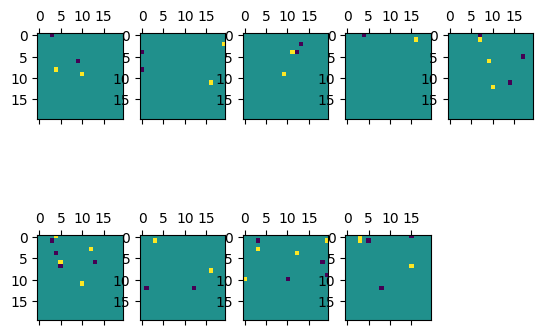

In [61]:
diffs = []
for i in range(n-1):
    mat_aa = matrices[i] - matrices[i+1]
    plt.subplot(2, n//2, i+1)
    plt.matshow(mat_aa, fignum=False)
    diff = sum(sum(np.abs(mat_aa)))
    diffs.append(diff)
print(diffs)
    
    

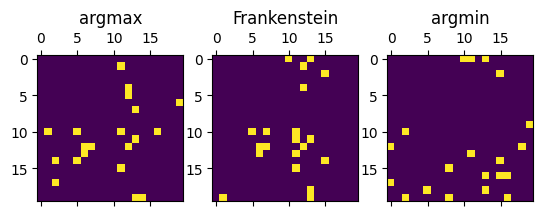

In [118]:
x, r = dataset[np.argmax(burned_r)]
mu, log_sigma = model.encode(x.unsqueeze(0))
x_, r_ = dataset[np.argmin(burned_r)]
mu_, log_sigma_ = model.encode(x_.unsqueeze(0))

frankenstein = mu_.clone()
frankenstein[0, 128:] = mu[0, 128:]
reconstrcuted_frankenstein = model.decode(frankenstein)
plt.subplot(1, 3, 1)
plt.title('argmax')
plt.matshow(top20(x[0]), fignum=False)
plt.subplot(1, 3, 3)
plt.title('argmin')
plt.matshow(top20(x_[0]), fignum=False)
plt.subplot(1, 3, 2)
plt.title('Frankenstein')
plt.matshow(top20(reconstrcuted_frankenstein[0][0]), fignum=False)
plt.show()

In [119]:
print(calc_fitness(model, mu.unsqueeze(0), n_sims=10))
print(calc_fitness(model, mu_.unsqueeze(0), n_sims=10))
print(calc_fitness(model, frankenstein.unsqueeze(0), n_sims=10))

/tmp/ipykernel_1407965/3499942404.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  indices = np.unravel_index(indices, (20, 20))


0.78125
0.67125
0.77025


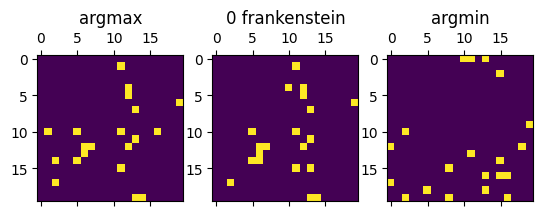

In [115]:
# taking all zeros as the starting point 
x, r = dataset[np.argmax(burned_r)]
mu, log_sigma = model.encode(x.unsqueeze(0))
x_, r_ = dataset[np.argmin(burned_r)]
mu_, log_sigma_ = model.encode(x_.unsqueeze(0))

frankenstein0 = torch.zeros_like(mu)
frankenstein0[0, 128:] = mu[0, 128:]
reconstrcuted_frankenstein0 = model.decode(frankenstein0)
plt.subplot(1, 3, 1)
plt.title('argmax')
plt.matshow(top20(x[0]), fignum=False)
plt.subplot(1, 3, 3)
plt.title('argmin')
plt.matshow(top20(x_[0]), fignum=False)
plt.subplot(1, 3, 2)
plt.title('0 frankenstein')
plt.matshow(top20(reconstrcuted_frankenstein0[0][0]), fignum=False)
plt.show()

In [114]:
print(calc_fitness(model, mu.unsqueeze(0), n_sims=10))
print(calc_fitness(model, mu_.unsqueeze(0), n_sims=10))
print(calc_fitness(model, frankenstein0.unsqueeze(0), n_sims=10))

/tmp/ipykernel_1407965/3499942404.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  indices = np.unravel_index(indices, (20, 20))


0.78125
0.67125
0.83675


In [138]:
def merge(mu1, mu2):
    merged = mu1.clone()
    merged[0, 128:] = mu2[0, 128:]
    return merged

In [124]:
def interpolate(model, x, x_, alpha):
    mu, log_sigma = model.encode(x.unsqueeze(0))
    mu_, log_sigma_ = model.encode(x_.unsqueeze(0))
    interpolations = []
    values = []
    return alpha * mu + (1 - alpha) * mu_

/tmp/ipykernel_1407965/3499942404.py:9: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  indices = np.unravel_index(indices, (20, 20))


0.67125
0.67125
0.7745
0.78125
0.78125
0.78125
0.78125
0.78125
0.78125
0.78125
0.78125
0.78125
0.78125
0.78125
0.78125
0.78125
0.78125
0.7875
0.7875
0.7875
0.7835
0.7835
0.7835
0.7835
0.7835
0.7835
0.7835
0.7835
0.7835


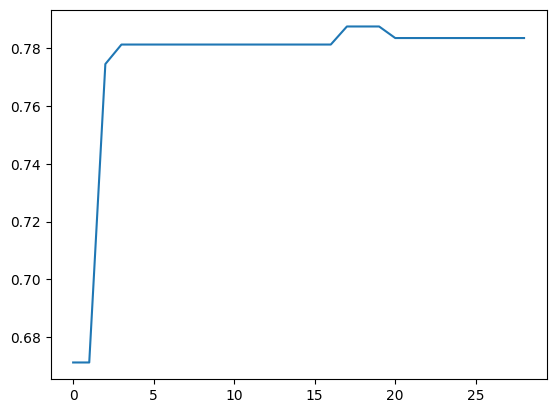

In [137]:
values = [-10,0,0.5,0.8,1,1.1,1.2,1.3,1.5,1.8,2,2.5,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100]
performance = []
for alpha in values:
    interpolate(model, x, x_, alpha)
    performance.append(calc_fitness(model, interpolate(model, x, x_, alpha).unsqueeze(0), n_sims=10))
    print(performance[-1])
plt.plot(performance)